In [25]:
import os
import errno
import numpy as np 
import deepcell
from deepcell_toolbox.processing import phase_preprocess
from deepcell.applications import MultiplexSegmentation

In [26]:
# create folder for this set of experiments
experiment_folder = "testing_models"
MODEL_DIR = os.path.join("/data/models", experiment_folder)
NPZ_DIR = "/data/npz_data/20201018_freeze/"
LOG_DIR = '/data/logs'

if not os.path.isdir(MODEL_DIR):
    os.makedirs(MODEL_DIR)

In [27]:
from deepcell.utils.data_utils import get_data
from skimage.segmentation import relabel_sequential

npz_name = "20201018_multiplex_final_seed_1_nuclear_"

train_dict = np.load(r"C:\Users\miles\GitHub\MESMER_training\training_datasets\tissuenet_v1.1\tissuenet_v1.1_train.npz")
val_dict = np.load(r"C:\Users\miles\GitHub\MESMER_training\training_datasets\tissuenet_v1.1\tissuenet_v1.1_val.npz")
X_train, y_train = train_dict['X'], train_dict['y']
X_val, y_val = val_dict['X'], val_dict['y']

In [46]:
print(np.shape(X_train))
print(np.shape(y_train))
print(np.shape(X_val))
print(np.shape(y_val))

(2580, 512, 512, 2)
(2580, 512, 512, 2)
(3118, 256, 256, 2)
(3118, 256, 256, 2)


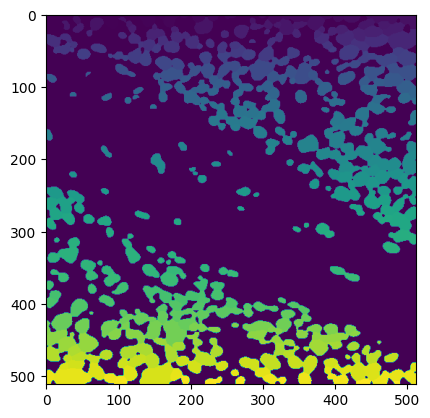

In [29]:
from matplotlib import pyplot as plt
plt.imshow(y_train[1,...,1], interpolation= None)

In [30]:
from skimage.exposure import rescale_intensity
from skimage.segmentation import find_boundaries
import copy
def make_color_overlay(input_data):
    """Create a color overlay from 2 channel image data
    
    Args:
        input_data: stack of input images
    
    Returns:
        numpy.array: color-adjusted stack of overlays in RGB mode
    """
    RGB_data = np.zeros(input_data.shape[:3] + (3, ), dtype='float32')
    
    # rescale channels to aid plotting
    for img in range(input_data.shape[0]):
        for channel in range(input_data.shape[-1]):
            # get histogram for non-zero pixels
            percentiles = np.percentile(input_data[img, :, :, channel][input_data[img, :, :, channel] > 0],
                                            [5, 95])
            rescaled_intensity = rescale_intensity(input_data[img, :, :, channel],
                                                       in_range=(percentiles[0], percentiles[1]),
                                                       out_range='float32')
            RGB_data[img, :, :, channel + 1] = rescaled_intensity
        
    # create a blank array for red channel
    return RGB_data

def make_outline_overlay(RGB_data, predictions):
    boundaries = np.zeros_like(predictions)
    overlay_data = copy.copy(RGB_data)
    
    for img in range(predictions.shape[0]):
        boundary = find_boundaries(predictions[img, :, :], connectivity=1, mode='inner')
        boundaries[img, boundary > 0] = 1

    overlay_data[boundaries > 0, :] = 1
    
    return overlay_data

In [31]:
rgb_data = make_color_overlay(X_train[2000:2030])
nuc_overlay = make_outline_overlay(rgb_data, y_train[2000:2030, :, :, 1])
cell_overlay = make_outline_overlay(rgb_data, y_train[2000:2030, :, :, 0])

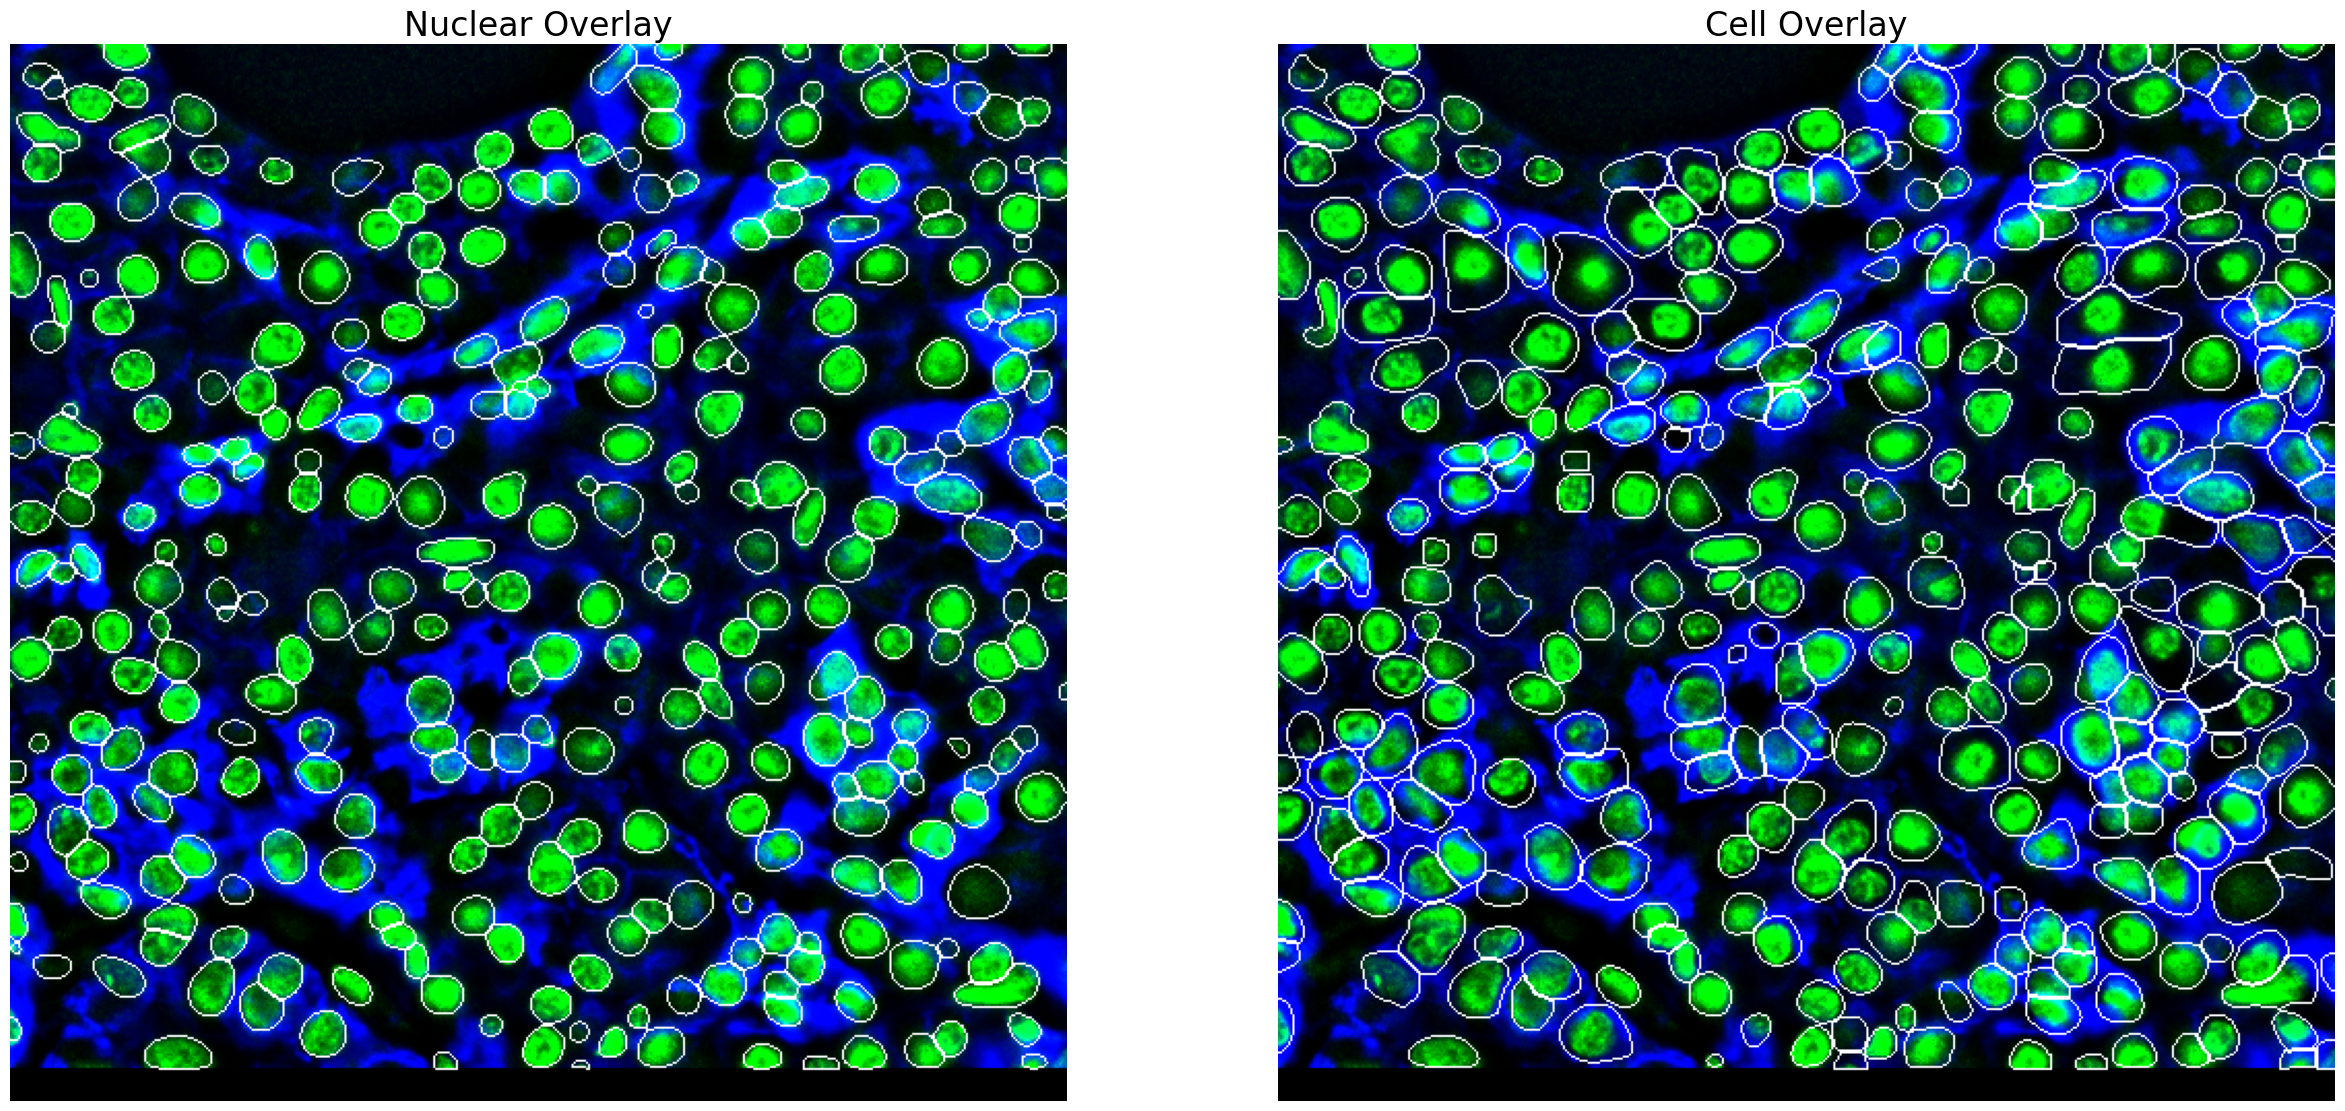

In [32]:
import matplotlib.pyplot as plt
cmap = plt.get_cmap('viridis')
cmap.set_bad('black')
index = 27
fig, axes = plt.subplots(1,2,figsize=(30,20))

axes = axes.flatten()
axes[0].imshow(nuc_overlay[index, ...], cmap=cmap)
axes[1].imshow(cell_overlay[index, ...], cmap=cmap)

axes[0].set_title('Nuclear Overlay', fontsize=24)
axes[1].set_title('Cell Overlay', fontsize=24)
# axes[5].set_title('Ground Truth Mask', fontsize=24)

for ax in axes.flatten():
    ax.set_axis_off()

In [33]:
from deepcell.model_zoo.panopticnet import PanopticNet

new_model = PanopticNet(
    backbone='resnet50',
    input_shape=(256, 256, 2),
    norm_method=None,
    num_semantic_heads=4,
    num_semantic_classes=[1, 3, 1, 3], # inner distance, pixelwise, inner distance, pixelwise
    location=True,  # should always be true
    include_top=True)

In [34]:
from tensorflow.keras.optimizers import SGD, Adam
from deepcell.utils.train_utils import rate_scheduler

model_name = npz_name + 'deep_watershed'

n_epoch = 100  # Number of training epochs

optimizer = Adam(lr=1e-4, clipnorm=0.001)
lr_sched = rate_scheduler(lr=1e-4, decay=0.99)

batch_size = 8

min_objects = 0  # throw out images with fewer than this many objects
seed=0
model_name

c:\Users\miles\GitHub\MESMER_Training\.venv\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


'20201018_multiplex_final_seed_1_nuclear_deep_watershed'

In [35]:
from deepcell import image_generators
from deepcell.utils import train_utils


# use augmentation for training but not validation
datagen = image_generators.CroppingDataGenerator(
    rotation_range=180,
    shear_range=0,
    zoom_range=(0.7, 1/0.7),
    horizontal_flip=True,
    vertical_flip=True,
    crop_size=(256, 256))

datagen_val = image_generators.SemanticDataGenerator(
    rotation_range=0,
    shear_range=0,
    zoom_range=0,
    horizontal_flip=0,
    vertical_flip=0)
    
train_data = datagen.flow(
    {'X': X_train, 'y': y_train},
    seed=seed,
    transforms=['inner-distance','pixelwise'],
    transforms_kwargs={'pixelwise':{'dilation_radius': 1}, 
                      'inner-distance': {'erosion_width': 1, 'alpha': 'auto'}},
    min_objects=min_objects,
    batch_size=batch_size)

val_data = datagen_val.flow(
    {'X': X_val, 'y': y_val},
    seed=seed,
    transforms=['inner-distance', 'pixelwise'],
    transforms_kwargs={'pixelwise':{'dilation_radius': 1},
                      'inner-distance': {'erosion_width': 1, 'alpha': 'auto'}},
    min_objects=min_objects,
    batch_size=batch_size)

c:\Users\miles\GitHub\MESMER_Training\.venv\lib\site-packages\deepcell\utils\transform_utils.py:84: FutureWarning: `selem` is a deprecated argument name for `binary_dilation`. It will be removed in version 1.0. Please use `footprint` instead.
  edge = binary_dilation(edge, selem=dil_strel)


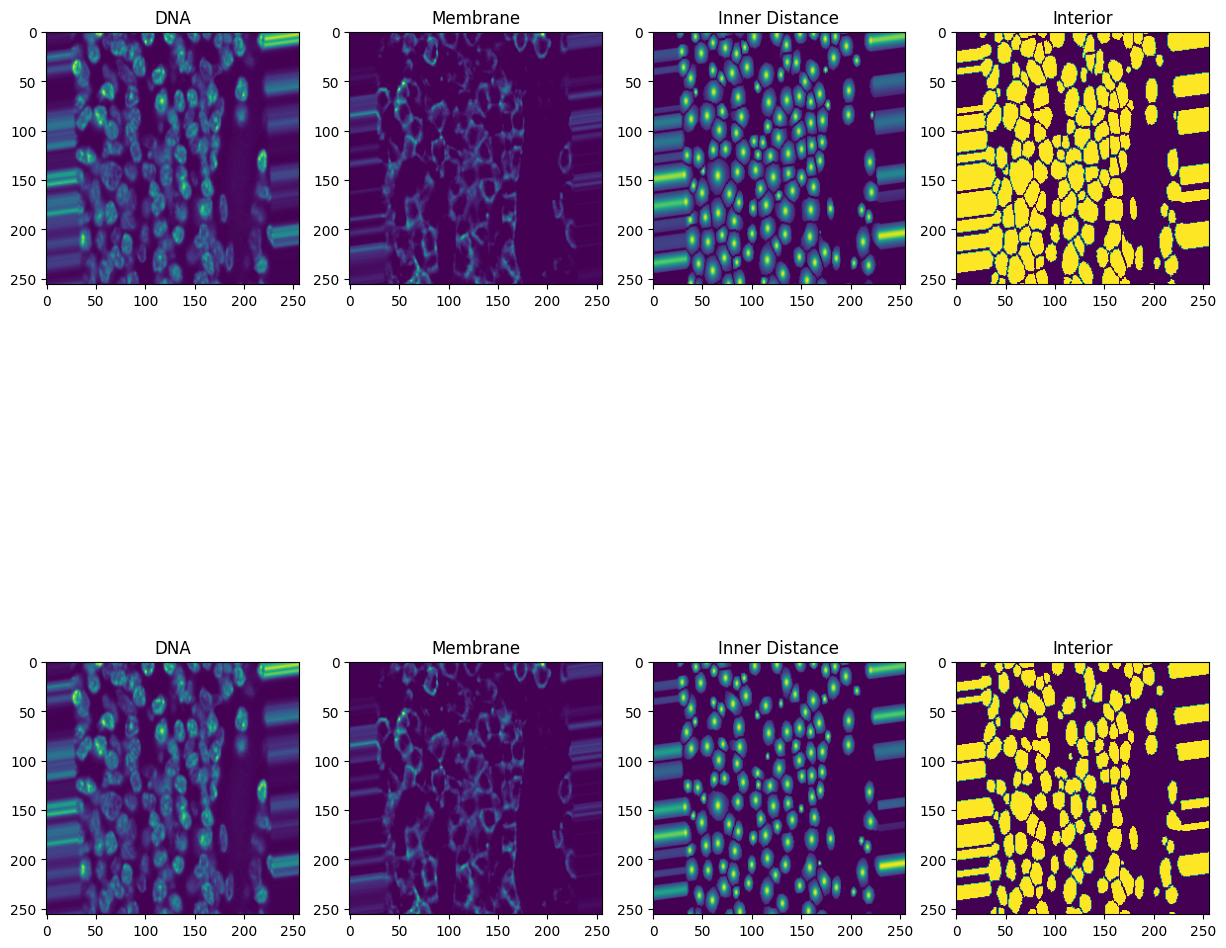

In [36]:
from matplotlib import pyplot as plt

inputs, outputs = train_data.next()

img = inputs[0]
inner_distance = outputs[0]
pixelwise = outputs[1]

inner_distance_nuc = outputs[2]
pixelwise_nuc = outputs[3]

fig, axes = plt.subplots(2, 4, figsize=(15, 15))

axes[0, 0].imshow(img[:, :, 0])
axes[0, 0].set_title('DNA')

axes[0, 1].imshow(img[:, :, 1])
axes[0, 1].set_title('Membrane')

axes[0, 2].imshow(inner_distance[0, ..., 0])
axes[0, 2].set_title('Inner Distance')

axes[0, 3].imshow(pixelwise[0, ..., 1])
axes[0, 3].set_title('Interior')

# nuclear
axes[1, 0].imshow(img[:, :, 0])
axes[1, 0].set_title('DNA')

axes[1, 1].imshow(img[:, :, 1])
axes[1, 1].set_title('Membrane')

axes[1, 2].imshow(inner_distance_nuc[0, ..., 0])
axes[1, 2].set_title('Inner Distance')

axes[1, 3].imshow(pixelwise_nuc[0, ..., 1])
axes[1, 3].set_title('Interior')

plt.show()

In [37]:
# Create a dictionary of losses for each semantic head
from tensorflow.python.keras.losses import MSE
from deepcell import losses


def semantic_loss(n_classes):
    def _semantic_loss(y_pred, y_true):
        if n_classes > 1:
            return 0.01 * losses.weighted_categorical_crossentropy(
                y_pred, y_true, n_classes=n_classes)
        return MSE(y_pred, y_true)
    return _semantic_loss


loss = {}

# Give losses for all of the semantic heads
for layer in new_model.layers:
    if layer.name.startswith('semantic_'):
        n_classes = layer.output_shape[-1]
        loss[layer.name] = semantic_loss(n_classes)

In [38]:
new_model.compile(loss=loss, optimizer=optimizer)

In [39]:
from deepcell.applications import Mesmer

In [40]:
mesmer_model = Mesmer()

In [41]:
mesmer_model = mesmer_model.model

In [44]:
mesmer_model.compile(loss=loss, optimizer=optimizer)

In [ ]:
from deepcell.utils.train_utils import get_callbacks
from deepcell.utils.train_utils import count_gpus


model_path = os.path.join(MODEL_DIR, '{}.h5'.format(model_name))
loss_path = os.path.join(MODEL_DIR, '{}.npz'.format(model_name))

num_gpus = count_gpus()

print('Training on', num_gpus, 'GPUs.')

train_callbacks = get_callbacks(
    model_path,
    lr_sched=lr_sched,
    tensorboard_log_dir=LOG_DIR,
    save_weights_only=num_gpus >= 2,
    monitor='val_loss',
    verbose=1)

loss_history = mesmer_model.fit(
    train_data,
    steps_per_epoch=train_data.y.shape[0] // batch_size,
    epochs=n_epoch,
    validation_data=val_data,
    validation_steps=val_data.y.shape[0] // batch_size,
    callbacks=train_callbacks)